In [45]:
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, WeightedRandomSampler
from AudioDataset import AudioDataset
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import random

In [46]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA device for GPU acceleration.")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device for GPU acceleration.")
else:
    device = torch.device("cpu")
    print("No GPU device found. Using CPU.")

Using MPS device for GPU acceleration.


In [47]:
import random

random.seed(42)
torch.manual_seed(42)

if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

In [48]:
class SpeechCNN(nn.Module):
    def __init__(self, n_classes=12, dropout_rate=0.3):
        super().__init__()
        
        # Feature extraction with more layers and batch normalization
        self.features = nn.Sequential(
            # First conv block
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # ↓ T/2
            
            # Second conv block
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # ↓ T/4
            
            # Third conv block - deeper representation
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d((2,1))  # Preserve frequency information
        )
        
        # Attention mechanism to focus on important features
        self.attention = nn.Sequential(
            nn.Conv2d(128, 1, kernel_size=1),
            nn.Sigmoid()
        )
        
        # Improved classifier with dropout for regularization
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate/2),
            nn.Linear(64, n_classes)
        )

    def forward(self, x):
        x = x.transpose(1, 2).unsqueeze(1)  # B×T×M → B×1×M×T
        
        # Extract features
        features = self.features(x)
        
        # Apply attention
        attn = self.attention(features)
        attended = features * attn
        
        # Classify
        return self.classifier(attended)


In [49]:
# # ─── prepare dataset ──────────────────────────────────────────────────────
# train_set = AudioDataset("./data/train_balanced.csv", "./data_raw/train/audio")
# labels = [lbl for _, lbl in train_set]              # list of ints
# counts = torch.bincount(torch.tensor(labels))       # #samples per class

# # ─── “soft” oversampling: cap max weight at e.g. 3× minority vs majority ──
# inv = 1.0 / counts.float()                          # raw inverse freq
# max_mult = 3.0
# capped = torch.minimum(inv, inv.max() * max_mult)

# sample_weights = [capped[lbl].item() for lbl in labels]

# sampler = WeightedRandomSampler(
#     sample_weights,
#     num_samples=len(sample_weights),
#     replacement=True
# )

# train_loader = DataLoader(
#     train_set,
#     batch_size=128,
#     sampler=sampler,
#     drop_last=True
# )

# # ─── test loader ────────────────────────────────────────────────────────
# test_set = AudioDataset("./data/test.csv", "./data_raw/train/audio")
# test_loader = DataLoader(
#     test_set,
#     batch_size=128,
#     shuffle=False,
#     drop_last=False
# )

In [50]:
# ─── prepare dataset ──────────────────────────────────────────────────────
train_set = AudioDataset(csv_path="./data/train_balanced.csv", audio_dir="./data_raw/train/audio")
train_loader = DataLoader(
    train_set,
    batch_size=128,
    shuffle=True,
    drop_last=True
)

# ─── test loader ────────────────────────────────────────────────────────
test_set = AudioDataset(csv_path="./data/test.csv", audio_dir="./data_raw/train/audio")
test_loader = DataLoader(
    test_set,
    batch_size=128,
    shuffle=False,
    drop_last=False
)

In [ ]:
model = SpeechCNN(n_classes=12).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(20):
    model.train()
    running = 0.0
    for i, (spec, labels) in enumerate(train_loader):
        spec, labels = spec.to(device), labels.to(device)

        optimizer.zero_grad()
        loss = criterion(model(spec), labels)
        loss.backward()
        optimizer.step()

        running += loss.item()
        if i % 10 == 0:
            print(f"Batch {i}, Loss: {loss.item():.4f}")
    # Print the average loss for the epoch
    print(f"Epoch {epoch+1}, Loss: {running/len(train_loader):.4f}")

Batch 0, Loss: 2.4967
Batch 10, Loss: 2.4484
Batch 20, Loss: 2.4062
Batch 30, Loss: 2.3330
Batch 40, Loss: 2.1963
Batch 50, Loss: 2.1627
Batch 60, Loss: 2.1538
Batch 70, Loss: 2.1082
Batch 80, Loss: 1.9736
Batch 90, Loss: 1.9854
Batch 100, Loss: 1.7840
Batch 110, Loss: 1.8743
Batch 120, Loss: 1.8203
Batch 130, Loss: 1.8278
Batch 140, Loss: 1.7947
Batch 150, Loss: 1.7253
Batch 160, Loss: 1.7265
Epoch 1, Loss: 2.0477
Batch 0, Loss: 1.6742
Batch 10, Loss: 1.7328
Batch 20, Loss: 1.6793
Batch 30, Loss: 1.6347
Batch 40, Loss: 1.3705
Batch 50, Loss: 1.3865
Batch 60, Loss: 1.4890
Batch 70, Loss: 1.3526
Batch 80, Loss: 1.2815
Batch 90, Loss: 1.4796
Batch 100, Loss: 1.4722
Batch 110, Loss: 1.3215
Batch 120, Loss: 1.5209
Batch 130, Loss: 1.3356
Batch 140, Loss: 1.4032
Batch 150, Loss: 1.2409
Batch 160, Loss: 1.3315
Epoch 2, Loss: 1.4684
Batch 0, Loss: 1.3180
Batch 10, Loss: 1.1538
Batch 20, Loss: 1.3767
Batch 30, Loss: 1.2031
Batch 40, Loss: 1.2036
Batch 50, Loss: 1.2125
Batch 60, Loss: 1.0827
Ba

In [ ]:
model.eval()
classes = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go", "silence", "unknown"]

all_preds, all_labels = [], []
n_correct = n_samples = 0
class_correct = [0]*12
class_total   = [0]*12

with torch.no_grad():
    for spec, labels in test_loader:
        spec, labels = spec.to(device), labels.to(device)
        preds = model(spec).argmax(1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        n_samples += labels.size(0)
        n_correct += (preds == labels).sum().item()
        for l, p in zip(labels, preds):
            class_total[l] += 1
            if l == p: class_correct[l] += 1

print(f"Accuracy: {100*n_correct/n_samples:.2f}%")
for i,c in enumerate(classes):
    print(f'Class "{c}": {100*class_correct[i]/class_total[i]:.2f}%')

Accuracy: 19.60%
Class "yes": 73.83%
Class "no": 90.08%
Class "up": 40.44%
Class "down": 57.71%
Class "left": 8.99%
Class "right": 40.15%
Class "on": 39.02%
Class "off": 37.79%
Class "stop": 26.51%
Class "go": 30.28%
Class "silence": 90.70%
Class "unknown": 4.03%


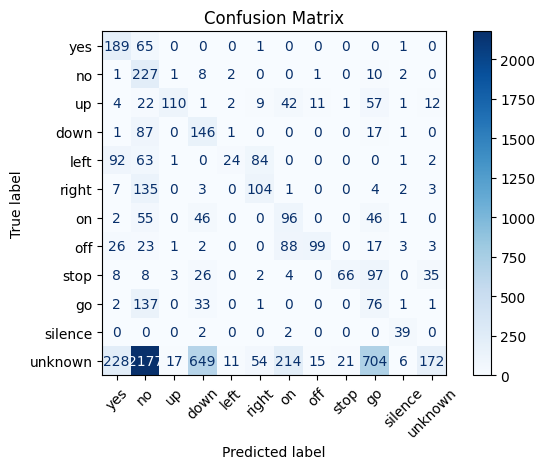

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
ConfusionMatrixDisplay(cm, display_labels=classes).plot(xticks_rotation=45, cmap="Blues")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()